In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM,GRU,Conv1D,MaxPooling1D,Flatten
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve,auc
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("../data/kddcup.data.corrected", sep=",", names=columns, index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)

(4898431, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [11]:
normal=df[(df["label"]=="normal.")&(df["src_bytes"]>0)&(df["src_bytes"]<300)]
normal=normal[["src_bytes","label"]]
print(normal["label"].value_counts())
#选出600000多数据用于分配和标准化
scaler= MinMaxScaler(feature_range = (0,1))
normal['value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(normal['src_bytes'])),columns=['src_bytes'])
normal=normal.dropna(axis=0,how='any')
normal=normal[normal["value"]>0]
normal=np.array(normal['value'])
print("normal:",normal)
timesquen=20
trim=len(normal)%timesquen
normal=normal[:len(normal)-trim]
normal.shape=(int(len(normal)/timesquen),timesquen,1)
print("normal",normal.shape)
train=normal[0:7000]
#validation=np.concatenate((normal[6000:10000],abnormal[0:1000]),axis=0)
#np.random.shuffle(validation)
#test=np.concatenate((normal[10000:12000],abnormal[0:800]),axis=0)
#np.random.shuffle(test)
validation=np.loadtxt('../data/collective_validation.csv',delimiter = ",")
test=np.loadtxt('../data/collective_test.csv',delimiter=",")

validation.shape=(int(len(validation)/timesquen),timesquen,1)
test.shape=(int(len(test)/timesquen),timesquen,1)
print(train.shape,validation.shape,test.shape)



normal.    622729
Name: label, dtype: int64
normal: [0.71812081 0.54026846 0.7885906  ... 0.34899329 0.09731544 0.34899329]
normal (12457, 20, 1)
(7000, 20, 1) (5000, 20, 1) (2800, 20, 1)


In [3]:
#LSTM
# time_steps = 20
# metric = 'mean_absolute_error'
# model = Sequential()
# model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
# print(model.summary())


In [84]:
#GRU
metric = 'mean_absolute_error'
model = Sequential()
model.add(GRU(units=32, activation='relu', input_shape=(20, 1), return_sequences=True))
model.add(GRU(units=16,activation='relu', return_sequences=True))
model.add(GRU(units=8,activation='relu', return_sequences=True))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_46 (GRU)                 (None, 20, 32)            3264      
_________________________________________________________________
gru_47 (GRU)                 (None, 20, 16)            2352      
_________________________________________________________________
gru_48 (GRU)                 (None, 20, 8)             600       
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 8)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 20, 1)             9         
Total params: 6,225
Trainable params: 6,225
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# convolutional layer parameters
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
x = Conv1D(filters=n_filters,
               kernel_size=filter_width,
             padding='causal',
              activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquen})(x)

model = Model(history_seq, pred_seq_train)
model.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
dense_11 (Dense)             (None, None, 128)         4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_12 (Dense)             (None, None, 1)           129       
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1)           0         
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________

In [14]:
from keras.callbacks import TensorBoard
tensorboard=tensorflow.keras.callbacks.TensorBoard(histogram_freq=1)
history=model.fit(train, train,
          batch_size=2**5,
          epochs=15,
          validation_data=(validation, validation))
         # callbacks = [tensorboard])


Train on 7000 samples, validate on 5000 samples
Epoch 1/15
7000/7000 [==============================] - 6s 793us/step - loss: 0.1029 - val_loss: 0.0078
Epoch 2/15
7000/7000 [==============================] - 3s 486us/step - loss: 0.0406 - val_loss: 0.0077
Epoch 3/15
7000/7000 [==============================] - 3s 495us/step - loss: 0.0375 - val_loss: 0.0086
Epoch 4/15
7000/7000 [==============================] - 3s 477us/step - loss: 0.0344 - val_loss: 0.0080
Epoch 5/15
7000/7000 [==============================] - 3s 473us/step - loss: 0.0312 - val_loss: 0.0129
Epoch 6/15
7000/7000 [==============================] - 3s 500us/step - loss: 0.0277 - val_loss: 0.0093
Epoch 7/15
7000/7000 [==============================] - 3s 478us/step - loss: 0.0243 - val_loss: 0.0116
Epoch 8/15
7000/7000 [==============================] - 3s 492us/step - loss: 0.0208 - val_loss: 0.0140
Epoch 9/15
7000/7000 [==============================] - 4s 557us/step - loss: 0.0175 - val_loss: 0.0121
Epoch 10/15
7000

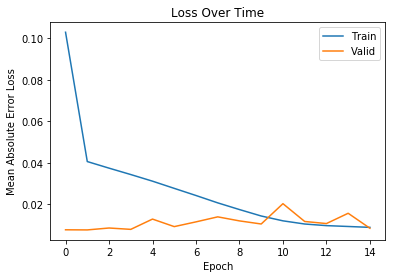

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [17]:
test_pred = model.predict(test)

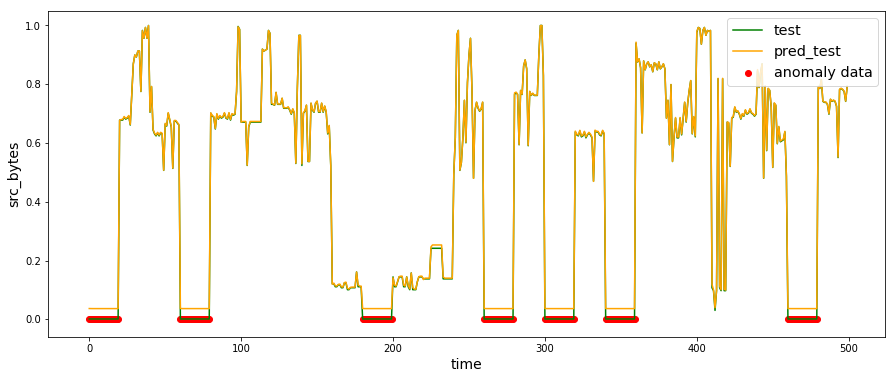

In [18]:
train1=train.reshape(train.shape[0]*train.shape[1],1)
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('src_bytes',fontsize=14)
plt.plot(test1[0:500],color="green")
plt.plot(test_pred1[0:500],color="orange",linestyle='-')
for i in range(500):
    if test1[i][0] == 0.001:
         plt.scatter(i,test1[i][0],color="red")
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [19]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)

PAthreshold=1#PAscores[PAcutoff]
print(PAthreshold)
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常


[3.24425281e-07 3.24425281e-07 3.81629739e-07 ... 3.55504026e-02
 3.55504026e-02 3.55504026e-02]
1


In [20]:
normal_rela_erro=0.0008
#集体集检测
timestep=20
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)

        

[0.         0.00488873 0.00519915 ... 0.70654039 0.70654039 0.70654039]


In [21]:
CAcutoff=int(0.63*len(CAscores))
CAthreshold=CAscores[CAcutoff]
print(CAscores[CAcutoff])

0.049635250296368616


In [22]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1

In [23]:
test_label=[]
for i in range(len(test1)):
    if test1[i]!= 0.001:
        test_label.append(0)#正常
    else :
        test_label.append(1)#异常

In [24]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(500):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

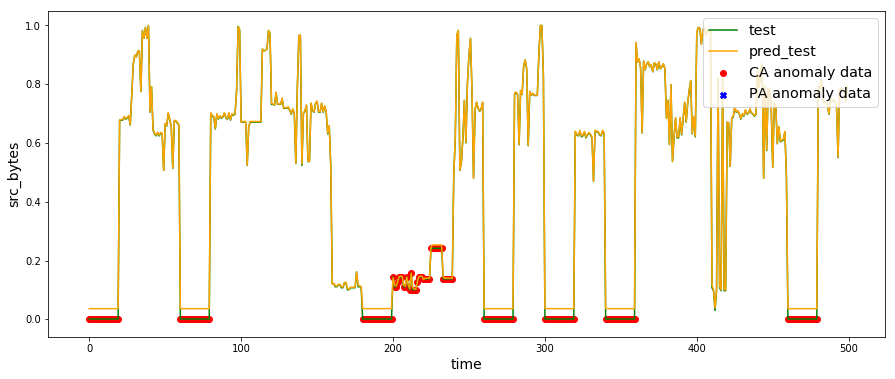

In [25]:
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('src_bytes',fontsize=14)
plt.plot(test1[0:500],color="green")
plt.plot(test_pred1[0:500],color="orange",linestyle='-')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend(('test','pred_test','CA anomaly data','PA anomaly data'),loc='upper right',fontsize='x-large')

In [152]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)
        

In [153]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC_AUC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC_AUC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR_AUC score:{:2%}".format(PR_AUC))

CA: 20720
PA: 0
ROC_AUC score:94.100000%
PR_AUC score:88.610039%


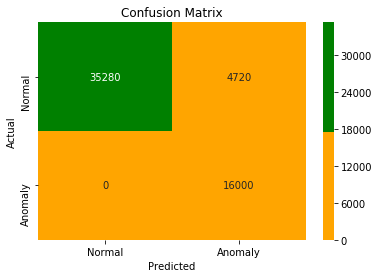

In [154]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)